# NOAA Automated Surface/Weather Observing Systems (ASOS/AWOS)
### Precipitation Data (Hourly) from 2010 to 2020, NYC, New York (Central Park, 40.779,-73.96925)

Author: Mark Bauer

Dataset: Automated Surface/Weather Observing Systems (ASOS/AWOS)  
ASOS Mainpage: https://www.ncei.noaa.gov/products/land-based-station/automated-surface-weather-observing-systems  
User guide: https://www.weather.gov/media/asos/aum-toc.pdf


Data retrieved from:  
Iowa State University Environmental Mesonet: https://mesonet.agron.iastate.edu/request/asos/hourlyprecip.phtml?network=NY_ASOS  
Station data: https://mesonet.agron.iastate.edu/sites/site.php?station=NYC&network=NY_ASOS  



Iowa Environmental Mesonet (IEM) Computed Hourly Precipitation Totals
> The IEM attempts to take the METAR reports of precipitation and then provide just the hourly precipitation totals. These totals are not for the true hour (00 to 59 after), but for the hour between the standard METAR reporting time, typically :53 or :54 after. The timestamps displayed are in Central Daylight/Standard Time and for the hour the precipitation fell. So a value for 5 PM would roughly represent the period between 4:53 and 5:53 PM.

# Importing Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.23.1
pandas           : 1.4.3
geopandas        : 0.11.1
geoplot          : 0.5.1
fiona            : 1.8.21
matplotlib.pyplot: unknown
seaborn          : 0.11.2



Documention for installing watermark: https://github.com/rasbt/watermark

# Retrieve Data

In [4]:
# path = 'https://mesonet.agron.iastate.edu/cgi-bin/request/hourlyprecip.py?network=NY_ASOS&station=NYC\
# &year1=2010&month1=1&day1=1&year2=2020&month2=12&day2=31&lalo=1&st=1&tz=America%2FNew_York'

# df = pd.read_csv(path)
# df.to_csv('data/hourlyprecip-nyc.csv', index=False)

In [5]:
ls data/

hourlyprecip-nyc.csv


# Read in Data

In [6]:
df = pd.read_csv('data/hourlyprecip-nyc.csv')

print(df.shape)
df.head()

(71597, 7)


,station,network,valid,precip_in,lat,lon,st
0,NYC,NY_ASOS,2010-01-01 01:00,0.0100,40.779,-73.96925,NY
1,NYC,NY_ASOS,2010-01-01 22:00,0.0001,40.779,-73.96925,NY
2,NYC,NY_ASOS,2010-01-01 23:00,0.0100,40.779,-73.96925,NY
3,NYC,NY_ASOS,2010-01-02 00:00,0.0001,40.779,-73.96925,NY
4,NYC,NY_ASOS,2010-01-02 04:00,0.0001,40.779,-73.96925,NY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    71597 non-null  object 
 1   network    71597 non-null  object 
 2   valid      71597 non-null  object 
 3   precip_in  71597 non-null  float64
 4   lat        71597 non-null  float64
 5   lon        71597 non-null  float64
 6   st         71597 non-null  object 
dtypes: float64(3), object(4)
memory usage: 3.8+ MB


In [8]:
df.describe()

,precip_in,lat,lon
count,71597.000000,71597.000,71597.00000
mean,0.007600,40.779,-73.96925
std,0.043277,0.000,0.00000
min,0.000000,40.779,-73.96925
25%,0.000000,40.779,-73.96925
50%,0.000000,40.779,-73.96925
75%,0.000000,40.779,-73.96925
max,1.660000,40.779,-73.96925


In [9]:
# to date_time
df['date_time'] = pd.to_datetime(df['valid'], infer_datetime_format=True)
df = df.sort_values(by='date_time').reset_index(drop=True)

df.head(10)

,station,network,valid,precip_in,lat,lon,st,date_time
0,NYC,NY_ASOS,2010-01-01 01:00,0.0100,40.779,-73.96925,NY,2010-01-01 01:00:00
1,NYC,NY_ASOS,2010-01-01 22:00,0.0001,40.779,-73.96925,NY,2010-01-01 22:00:00
2,NYC,NY_ASOS,2010-01-01 23:00,0.0100,40.779,-73.96925,NY,2010-01-01 23:00:00
3,NYC,NY_ASOS,2010-01-02 00:00,0.0001,40.779,-73.96925,NY,2010-01-02 00:00:00
4,NYC,NY_ASOS,2010-01-02 04:00,0.0001,40.779,-73.96925,NY,2010-01-02 04:00:00
5,NYC,NY_ASOS,2010-01-02 05:00,0.0001,40.779,-73.96925,NY,2010-01-02 05:00:00
6,NYC,NY_ASOS,2010-01-02 06:00,0.0001,40.779,-73.96925,NY,2010-01-02 06:00:00
7,NYC,NY_ASOS,2010-01-03 09:00,0.0001,40.779,-73.96925,NY,2010-01-03 09:00:00
8,NYC,NY_ASOS,2010-01-03 10:00,0.0001,40.779,-73.96925,NY,2010-01-03 10:00:00
9,NYC,NY_ASOS,2010-01-03 14:00,0.0001,40.779,-73.96925,NY,2010-01-03 14:00:00


In [10]:
df.tail(10)

,station,network,valid,precip_in,lat,lon,st,date_time
71587,NYC,NY_ASOS,2020-12-30 15:00,0.0,40.779,-73.96925,NY,2020-12-30 15:00:00
71588,NYC,NY_ASOS,2020-12-30 16:00,0.0,40.779,-73.96925,NY,2020-12-30 16:00:00
71589,NYC,NY_ASOS,2020-12-30 17:00,0.0,40.779,-73.96925,NY,2020-12-30 17:00:00
71590,NYC,NY_ASOS,2020-12-30 18:00,0.0,40.779,-73.96925,NY,2020-12-30 18:00:00
71591,NYC,NY_ASOS,2020-12-30 19:00,0.0,40.779,-73.96925,NY,2020-12-30 19:00:00
71592,NYC,NY_ASOS,2020-12-30 20:00,0.0,40.779,-73.96925,NY,2020-12-30 20:00:00
71593,NYC,NY_ASOS,2020-12-30 21:00,0.0,40.779,-73.96925,NY,2020-12-30 21:00:00
71594,NYC,NY_ASOS,2020-12-30 22:00,0.0,40.779,-73.96925,NY,2020-12-30 22:00:00
71595,NYC,NY_ASOS,2020-12-30 23:00,0.0,40.779,-73.96925,NY,2020-12-30 23:00:00
71596,NYC,NY_ASOS,2020-12-31 00:00,0.0,40.779,-73.96925,NY,2020-12-31 00:00:00


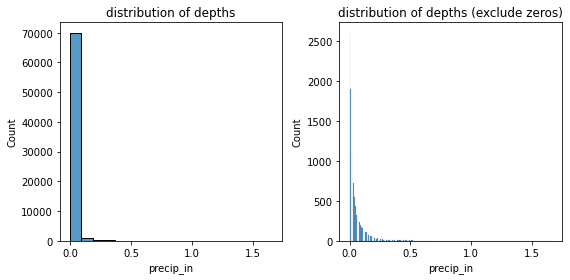

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(df['precip_in'],
             ax=axs[0])
axs[0].set_title('distribution of depths')

# removing zeros
sns.histplot(data=df.loc[df['precip_in'] > 0],
             x='precip_in',
             ax=axs[1])
axs[1].set_title('distribution of depths (exclude zeros)')

fig.tight_layout()

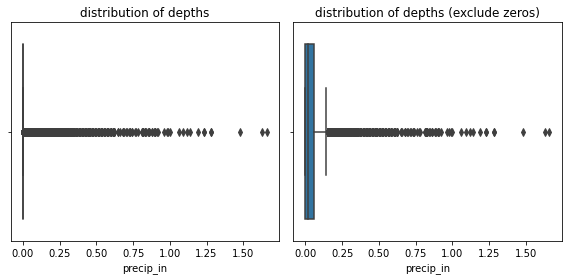

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(x=df["precip_in"],
             ax=axs[0])
axs[0].set_title('distribution of depths')

# removing zeros
sns.boxplot(data=df.loc[df["precip_in"] > 0],
             x='precip_in',
             ax=axs[1])
axs[1].set_title('distribution of depths (exclude zeros)')

fig.tight_layout()

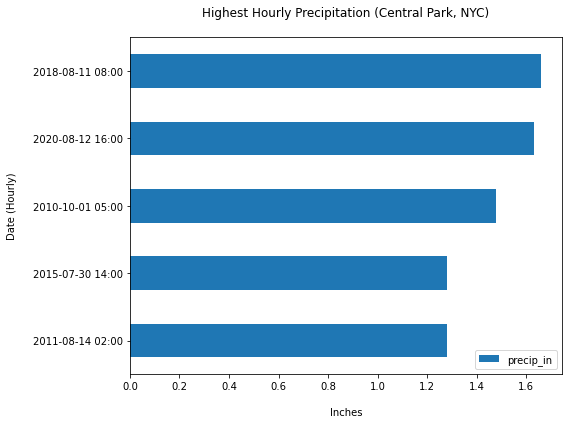

In [13]:
# highest values
fig, ax = plt.subplots(figsize=(8, 6))

(df
 .sort_values(by='precip_in', ascending=False)
 .loc[:, ['valid', 'precip_in']]
 .head()
 .sort_values(by='precip_in')
 .plot
 .barh(x='valid', y='precip_in', ax=ax)
)

plt.title('Highest Hourly Precipitation (Central Park, NYC)\n')
plt.ylabel('Date (Hourly)\n')
plt.xlabel('\nInches')
plt.tight_layout()

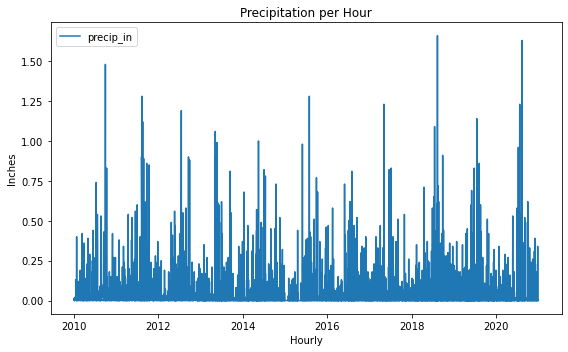

In [14]:
plt.figure(figsize=(8, 5))

data = df.set_index(df['date_time']).loc[:, ['precip_in']]
sns.lineplot(data=data)

plt.title('Precipitation per Hour')
plt.xlabel('Hourly')
plt.ylabel('Inches')
plt.tight_layout()

# Retrieve datetime attributes

In [15]:
# https://pandas.pydata.org/docs/reference/api/pandas.Period.strftime.html
df['year_month_day'] = df['date_time'].dt.strftime('%Y-%m-%d')
df['year_month_week'] = df['date_time'].dt.strftime('%Y-%W')
df['year_month'] = df['date_time'].dt.strftime('%Y-%m')
df['date_formatted'] = df['date_time'].dt.strftime('%Y-%b')

# to date_time
df['year_month_day'] = pd.to_datetime(df['year_month_day'])
df['year_month'] = pd.to_datetime(df['year_month'])
df['year_month_week'] = pd.to_datetime(df['year_month_week'] + '0', format='%Y-%W%w')

# various datetime attributes
df['time'] = df['date_time'].dt.time
df['hour'] = df['date_time'].dt.hour
df['am_pm'] = df['date_time'].dt.strftime('%p')
df['day'] = df['date_time'].dt.day
df['day_name'] = df['date_time'].dt.day_name()
df['week_of_year'] = df['date_time'].dt.isocalendar().week
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

df.iloc[:, 7:].head()

,date_time,year_month_day,year_month_week,year_month,date_formatted,time,hour,am_pm,day,day_name,week_of_year,quarter,month,year
0,2010-01-01 01:00:00,2010-01-01,2010-01-03,2010-01-01,2010-Jan,01:00:00,1,AM,1,Friday,53,1,1,2010
1,2010-01-01 22:00:00,2010-01-01,2010-01-03,2010-01-01,2010-Jan,22:00:00,22,PM,1,Friday,53,1,1,2010
2,2010-01-01 23:00:00,2010-01-01,2010-01-03,2010-01-01,2010-Jan,23:00:00,23,PM,1,Friday,53,1,1,2010
3,2010-01-02 00:00:00,2010-01-02,2010-01-03,2010-01-01,2010-Jan,00:00:00,0,AM,2,Saturday,53,1,1,2010
4,2010-01-02 04:00:00,2010-01-02,2010-01-03,2010-01-01,2010-Jan,04:00:00,4,AM,2,Saturday,53,1,1,2010


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   station          71597 non-null  object        
 1   network          71597 non-null  object        
 2   valid            71597 non-null  object        
 3   precip_in        71597 non-null  float64       
 4   lat              71597 non-null  float64       
 5   lon              71597 non-null  float64       
 6   st               71597 non-null  object        
 7   date_time        71597 non-null  datetime64[ns]
 8   year_month_day   71597 non-null  datetime64[ns]
 9   year_month_week  71597 non-null  datetime64[ns]
 10  year_month       71597 non-null  datetime64[ns]
 11  date_formatted   71597 non-null  object        
 12  time             71597 non-null  object        
 13  hour             71597 non-null  int64         
 14  am_pm            71597 non-null  objec

Nice tutorial about resampling: https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/resample-time-series-data-pandas-python/

In [17]:
# Resample to daily precip max and save as new dataframe
daily = df.set_index('date_time')[['precip_in']].resample('D').max()

daily.describe()

,precip_in
count,3324.000000
mean,0.062914
std,0.150340
min,0.000000
25%,0.000000
50%,0.000000
75%,0.050000
max,1.660000


In [18]:
# Resample to weekly precip max and save as new dataframe
weekly = df.set_index('date_time')[['precip_in']].resample('W').max()

weekly.describe()

,precip_in
count,567.000000
mean,0.243706
std,0.260654
min,0.000000
25%,0.070000
50%,0.160000
75%,0.340000
max,1.660000


In [19]:
# Resample to monthly precip max and save as new dataframe
monthly = df.set_index('date_time')[['precip_in']].resample('M').max()

monthly.describe()

,precip_in
count,132.000000
mean,0.509621
std,0.323965
min,0.030000
25%,0.270000
50%,0.425000
75%,0.620000
max,1.660000


In [20]:
# Resample to yearly precip max and save as new dataframe
yearly = df.set_index('date_time')[['precip_in']].resample('Y').max()

yearly.describe()

,precip_in
count,11.000000
mean,1.250909
std,0.259902
min,0.810000
25%,1.100000
50%,1.230000
75%,1.380000
max,1.660000


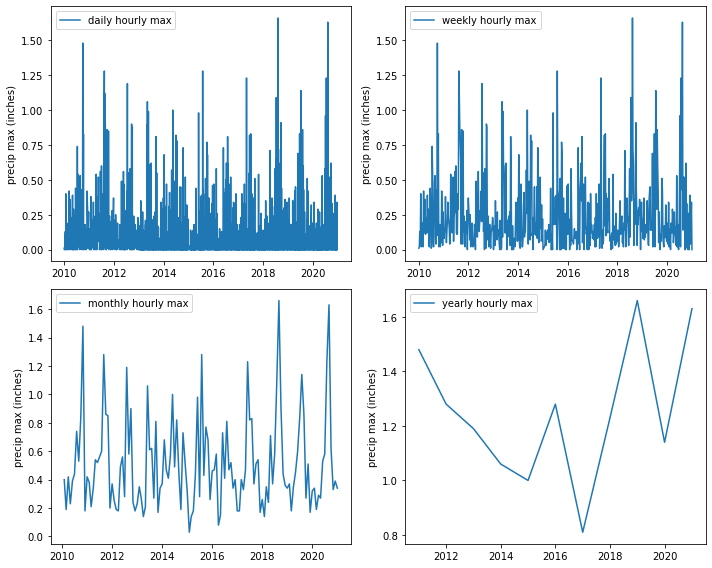

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

dfs = [daily, weekly, monthly, yearly]
labels = ['daily', 'weekly', 'monthly', 'yearly']

for data, label, ax in zip(dfs, labels, axs.flat):
    sns.lineplot(data=data, ax=ax, legend=False)
    ax.legend(['{} hourly max'.format(label)])
    ax.set_ylabel('precip max (inches)')
    ax.set_xlabel('')

fig.tight_layout()

In [22]:
# Resample to daily precip sum and save as new dataframe
daily_sum = df.set_index('date_time')[['precip_in']].resample('D').sum()

daily_sum.describe()

,precip_in
count,4018.000000
mean,0.135428
std,0.373793
min,0.000000
25%,0.000000
50%,0.000000
75%,0.050300
max,5.810100


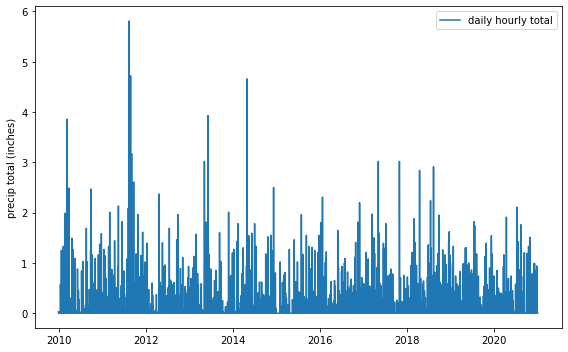

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=daily_sum, ax=ax, legend=False)
ax.legend(['daily hourly total'])
ax.set_ylabel('precip total (inches)')
ax.set_xlabel('')

plt.tight_layout()

In [24]:
# Resample to hourly precip max and save as new dataframe
hourly = df.set_index('date_time')[['precip_in']].resample('H').max()

hourly.describe()

,precip_in
count,71589.000000
mean,0.007601
std,0.043279
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.660000


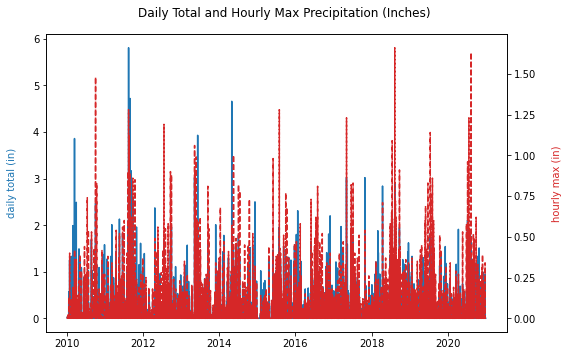

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()

sns.lineplot(data=daily_sum, ax=ax, palette=('tab:blue', ), legend=False)
sns.lineplot(data=hourly, ax=ax2, palette=('tab:red', ), legend=False)
ax2.lines[0].set_linestyle("--")

ax.set_ylabel('daily total (in)\n', color='tab:blue')
ax2.set_ylabel('\nhourly max (in)',  color='tab:red')
ax.set_xlabel('')

plt.suptitle('Daily Total and Hourly Max Precipitation (Inches)')
plt.tight_layout()

# Rolling Averages

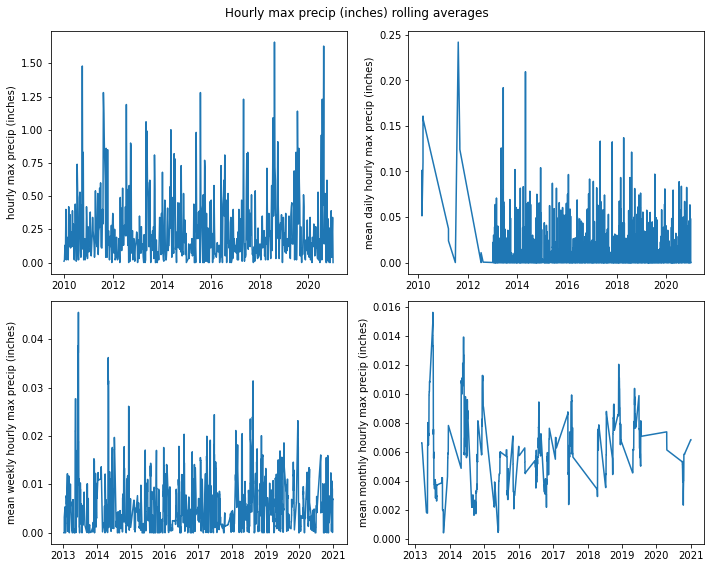

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

hourly = df.set_index('date_time')[['precip_in']].resample('H').max()
rolling_day = df.set_index('date_time')[['precip_in']].resample('H').max().rolling(24).mean()
rolling_week = df.set_index('date_time')[['precip_in']].resample('H').max().rolling(24 * 7).mean()
rolling_month = df.set_index('date_time')[['precip_in']].resample('H').max().rolling(24 * 31).mean()

dfs = [weekly, rolling_day, rolling_week, rolling_month,]
labels = ['hourly', 'daily', 'weekly', 'monthly', 'yearly']

for data, label, ax in zip(dfs, labels, axs.flat):
    sns.lineplot(data=data, ax=ax, legend=False)
    ax.set_ylabel('mean {} hourly max precip (inches)'.format(label))
    ax.set_xlabel('')
axs[0,0].set_ylabel('hourly max precip (inches)')    

plt.suptitle('Hourly max precip (inches) rolling averages')
fig.tight_layout()